In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import rasterio
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU, IoU

In [173]:
mapping = {0:'Unknown',
           1:'Unknown cropland',
           2:'Cereals',
           4:'Woods and tree crops',
           7:'Forage',
           9:'Maize',
           12:'Rice',
           3:'Unknown cropland',
           5:'Unknown cropland',
           6:'Unknown cropland',
           8:'Unknown cropland',
           10:'Unknown cropland',
           11:'Unknown cropland',
           13:'Unknown cropland',
           14:'Unknown cropland',
           15:'Unknown cropland',
           16:'Unknown cropland',
           20:'Unknown cropland',
           1:'Unknown cropland',
           17:'No agricultural land',
           18:'No agricultural land',
           19:'No agricultural land',
           21:'No agricultural land',}

# Preprocessing

In [235]:
def scaling(arr:list, pos:int, a:float=0, b:float=1, clip:bool=True, temporal:bool=False):
    '''
    Performs a linear transformation on each channel of a given satellite image. Array must be of dimension 4.

    normalized_band = (value - c) * (b - a) / (d - c) + a

    https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af

    arr : array to be scaled with a linear transformation
    pos : index of the number of channels
    a : lower limit of the resulting range
    b : upper limit of the resulting range
    clip : whether to bound the interval or not
    temporal : boolean to indicate if we have temporal dimension
    '''

    if pos != arr.ndim-1:
        if pos != -1:
            arr = np.moveaxis(arr, pos, -1)

    # Linear normalization https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af
    res = []


    for i in range(arr.shape[-1]):
        band = arr[:,:,:,:,i] if temporal else arr[:,:,:,i]
        c = np.percentile(band, 1)
        d = np.percentile(band, 99)
        normalized_band = (band - c) * (b - a) / (d-c) + a
        res.append(normalized_band)

    if clip==True:
        return np.clip(np.stack(res, axis=pos),0,1)

    return np.stack(res, axis=pos)

In [3]:
X = np.load('../data/kaggle_dataset/X.npy')
data = scaling(X, 1)
data = np.moveaxis(data, 1, 3)
data_small = data[:300,:,:,:]
data.shape

(3328, 48, 48, 9)

In [6]:
y = np.load('../data/kaggle_dataset/y.npy')
y = y-1 #First category must be 0
y = np.moveaxis(y, 1, 3)
y.shape

(3328, 48, 48, 1)

# Unet Model

In [51]:
def metrics(n_classes:int, sparse_y_pred:bool=False, sparse_y_true:bool=False):
    '''
    Return a list with MeanIoU as first argument and IoU for each given class.
    '''
    l = [MeanIoU(num_classes=n_classes, sparse_y_pred=sparse_y_pred, sparse_y_true=sparse_y_true)]

    for i in range(n_classes):
        l.append(IoU(num_classes=n_classes, target_class_ids=[i],sparse_y_pred=sparse_y_pred, sparse_y_true=sparse_y_true))

    return l

In [52]:
#https://youtu.be/csFGTLT6_WQ
# u-net model

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from torchmetrics.classification import MulticlassJaccardIndex


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(21, 1, activation='softmax', padding='same')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=metrics(21)) #Ignore class to exclude background
    model.summary()

    return model

In [53]:
y_cat = tf.keras.utils.to_categorical(y)

y_cat_small = y_cat[:300]

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y_cat, test_size=0.2)


In [55]:
model = simple_unet_model(48, 48, 9)

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=0
    )

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=16,
    callbacks=[es],
    epochs=100)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 48, 48, 9) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 48, 48,    │      1,312 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 48, 48,    │          0 │ conv2d_76[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 48, 48,    │      2,320 │ dropout_36[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 24, 24,    │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 24, 24,    │      4,640 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 24, 24,    │          0 │ conv2d_78[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 24, 24,    │      9,248 │ dropout_37[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 12, 12,    │          0 │ conv2d_79[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 12, 12,    │     18,496 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 12, 12,    │          0 │ conv2d_80[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 12, 12,    │     36,928 │ dropout_38[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 6, 6, 64)  │          0 │ conv2d_81[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 6, 6, 128) │     73,856 │ max_pooling2d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 6, 6, 128) │          0 │ conv2d_82[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 6, 6, 128) │    147,584 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 3, 3, 128) │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,942,309 (7.41 MB)

 Trainable params: 1,942,309 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - io_u_64: 2.5294e-04 - io_u_65: 0.0349 - io_u_66: 0.0000e+00 - io_u_67: 0.0012 - io_u_68: 0.0032 - io_u_69: 9.6427e-04 - io_u_70: 0.1370 - io_u_71: 0.0028 - io_u_72: 0.3313 - io_u_73: 0.0000e+00 - io_u_74: 0.0066 - io_u_75: 0.0000e+00 - io_u_76: 0.0000e+00 - io_u_77: 0.0000e+00 - io_u_78: 0.0000e+00 - io_u_79: 0.0000e+00 - io_u_80: 0.0014 - io_u_81: 0.0000e+00 - io_u_82: 1.6259e-04 - io_u_83: 0.0076 - io_u_84: 0.0000e+00 - loss: 0.5233 - mean_io_u_5: 0.0251 - val_io_u_64: 0.0000e+00 - val_io_u_65: 0.0049 - val_io_u_66: 0.0000e+00 - val_io_u_67: 0.0000e+00 - val_io_u_68: 0.0000e+00 - val_io_u_69: 0.0000e+00 - val_io_u_70: 0.2639 - val_io_u_71: 0.0000e+00 - val_io_u_72: 0.3690 - val_io_u_73: 0.0000e+00 - val_io_u_74: 0.0000e+00 - val_io_u_75: 0.0000e+00 - val_io_u_76: 0.0000e+00 - val_io_u_77: 0.0000e+00 - val_io_u_78: 0.0000e+00 - val_io_u_79: 0.0000e+00 - val_io_u_80: 3.8269e-04 - val_io_u_81: 0.0000e+00 - val_io_u_82: 0.0000e+00

In [56]:
def plot_lc(metric:str):
    '''
    Plot the learning curves for a given metric. The metric should be written with lower_case_snake.
    ex metric = mean_io_u
    '''
    fig, axs = plt.subplot_mosaic('AB')

    fig.set_figheight(5)
    fig.set_figwidth(10)
    fig.suptitle('Learning curves')

    axs['A'].plot(history.history['loss'], label='Train')
    axs['A'].plot(history.history['val_loss'], label='Validation')
    axs['A'].set_title('Loss')
    axs['A'].legend()

    axs['B'].plot(history.history[metric], label='Train')
    axs['B'].plot(history.history[f'val_{metric}'], label='Validation')
    axs['B'].set_title(metric)
    axs['B'].legend()

    fig.show()


In [174]:
def plot_multiple_lc(history:dict, n_classes:int, classes:list, mapping:dict):
    '''
    Plot the learning curves with loss, mean_iou and some iou of given classes.

    history : History of the model
    n_classes : number of classes we want to predict
    classes : list of integers representing the categories for which we would like to plot the IoU
    mapping : dictionnary with key corresponding to the label of the category and value is the name of the category
    '''

    keys = list(history.history.keys())

    fig, axs = plt.subplot_mosaic('AC;BB')

    fig.set_figheight(13)
    fig.set_figwidth(13)
    fig.suptitle('Learning curves')

    axs['A'].plot(history.history['loss'], label='Train')
    axs['A'].plot(history.history['val_loss'], label='Validation')
    axs['A'].set_title('Loss')
    axs['A'].legend()

    for i in classes:
        axs['B'].plot(history.history[keys[i]], label=f'Train - {mapping[i]}')
        axs['B'].plot(history.history[f'val_{keys[i]}'], label=f'Validation - {mapping[i]}')

    axs['B'].set_title('IoU per class')
    axs['B'].legend(loc='right')

    axs['C'].plot(history.history[keys[n_classes+1]], label='Train')
    axs['C'].plot(history.history[keys[-1]], label='Validation')
    axs['C'].set_title('Mean IoU')
    axs['C'].legend()

    fig.show()

In [227]:
unique, counts = np.unique(y, return_counts=True)

arr = np.array((unique, (counts / counts.sum())*100), dtype=int).T

l = []

for val in arr:
    if val[1]!=0:
        l.append(val[0])

l

[1, 3, 4, 5, 6, 8, 10, 14, 16, 19]

/var/folders/l5/vly43pj15qx6yny3zx9z54pr0000gn/T/ipykernel_2672/2001949331.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


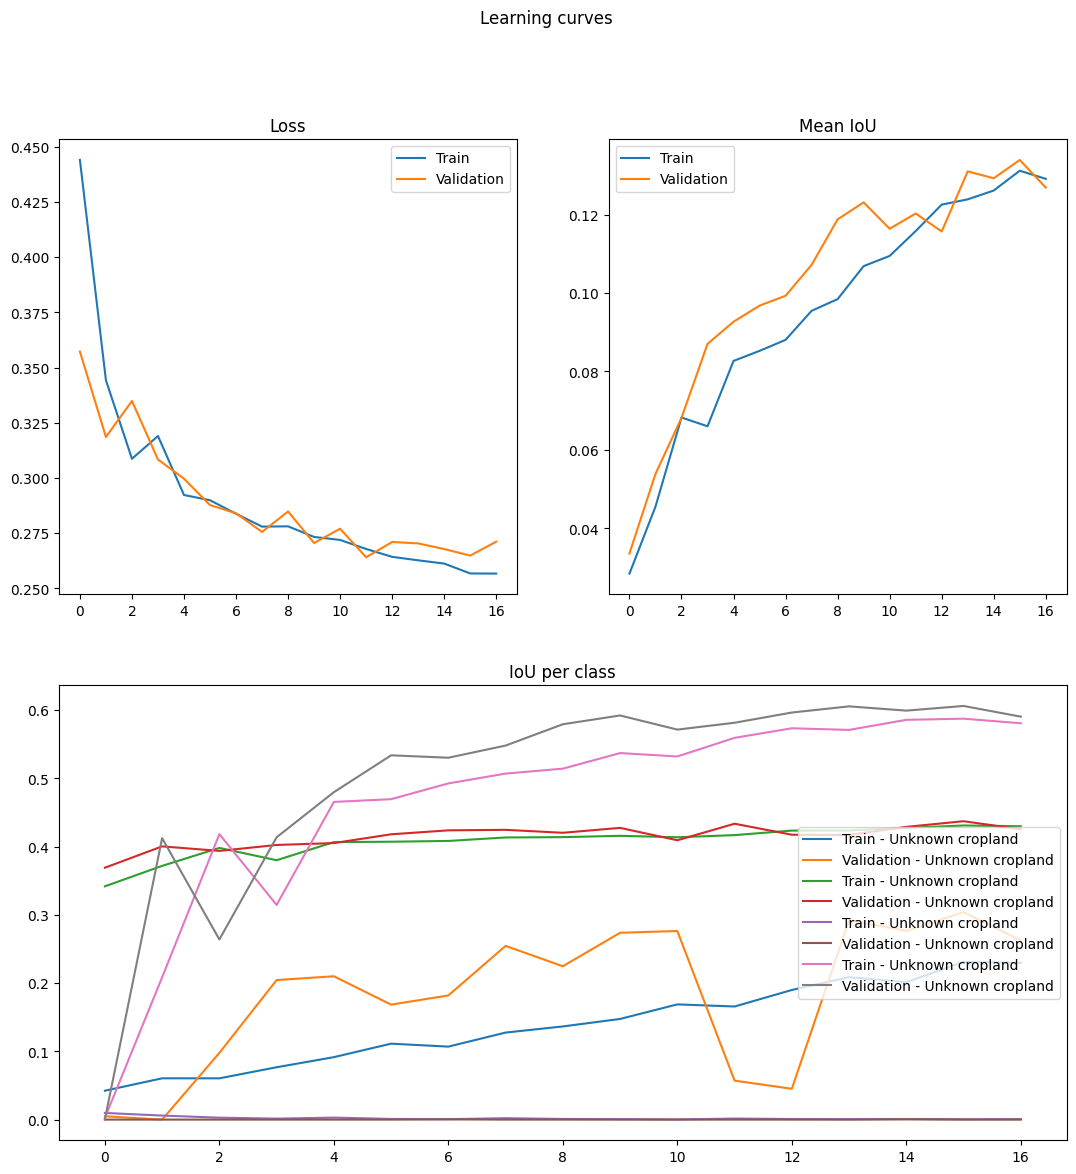

In [176]:
plot_multiple_lc(history, 21, [1,8,10,16], mapping)

In [146]:
y_pred = model.predict(X_test)
y_pred.shape , y_test.shape

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


((666, 48, 48, 21), (666, 48, 48, 21))

In [225]:
y_pred_sparse = y_pred.argmax(axis=3)
y_truth_sparse = y_test.argmax(axis=3)

(666, 48, 48)

In [224]:
def analyse_proportions(y_truth:list, y_pred:list,mapping:dict):
    '''
    Returns a dataframe sorted by proportion of ground truth categories. Compare them to the prediction proportions.

    y_truth :  array corresponding to the ground truth image with labels from 0 to number of classes
    y_pred : array corresponding to the prediction
    mapping : dictionnary with key corresponding to the label of the category and value is the name of the category

    '''
    unique_truth, counts_truth = np.unique(y_truth, return_counts=True)
    prop_truth = np.round(counts_truth / counts_truth.sum() * 100, 1)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    prop_preds = np.round(counts_pred / counts_pred.sum() *100, 1)

    unique_truth, unique_pred

    df_truth = pd.DataFrame({'Id':unique_truth, 'Truth':prop_truth})
    df_pred = pd.DataFrame({'Id':unique_pred, 'Pred':prop_preds})

    df = df_truth.merge(df_pred, on='Id', how='outer').fillna(0).sort_values('Truth', ascending=False)

    df.set_index('Id', inplace=True)

    a = pd.Series(df.index.map(mapping))
    df.insert(0, 'Category', a)

    return df

analyse_proportions(y_truth_sparse, y_pred_sparse, mapping)

,Category,Truth,Pred
Id,,,
8,Unknown cropland,31.9,63.1
6,Unknown cropland,17.9,19.1
1,Unknown cropland,12.3,1.5
16,Rice,10.1,12.6
10,No agricultural land,9.1,0.0
19,NaN,5.7,0.7
5,No agricultural land,5.4,0.0
14,Forage,1.8,0.8
3,Unknown cropland,1.7,0.8


In [192]:
import matplotlib as mpl
def plot_comparison(y_truth:list, y_pred:list, n_classes:int, mapping:dict):
    '''
    Plot the ground truth versus the prediction of the model for three random images of the dataset.
    Also plot the difference between ground truth and the prediction, green corresponding to a right prediction.

    y_truth : array with the truth labels
    y_pred : array with the predicted labels
    n_classes : number of categories we want to predict

    '''
    colors = ['mediumseagreen', 'tomato']
    bounds = [0,1]

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    colors = ['blue',
            'lightsteelblue',
            'cornflowerblue',
            'slategrey',
            'lavender',
            'salmon',
            'orange',
            'red',
            'orangered',
            'sienna',
            'darkslategray',
            'darkcyan',
            'aqua',
            'skyblue',
            'pink',
            'wheat',
            'bisque',
            'forestgreen',
            'yellow',
            'powderblue',
            'rosybrown']
    bounds = np.arange(n_classes)

    cmapbis = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmapbis.N)

    fig, axs = plt.subplot_mosaic('ABC;DEF;HIJ')

    fig.set_figheight(10)
    fig.set_figwidth(13)
    fig.suptitle('Comparison predictions with ground truth')

    random_val = np.random.randint(0, X_test.shape[0],3)

    axs['A'].imshow(y_truth[random_val[0]], cmap=cmapbis, norm=norm)
    axs['A'].set_title('Ground truth')
    axs['B'].imshow(y_pred[random_val[0]], cmap=cmapbis, norm=norm)
    axs['B'].set_title('Prediction')
    a = y_truth[random_val[0]] - y_pred[random_val[0]]
    axs['C'].imshow(np.where(a == 0, a, 1), cmap=cmap, norm=norm)
    axs['C'].set_title('Difference')

    axs['D'].imshow(y_truth[random_val[1]], cmap=cmapbis, norm=norm)
    axs['E'].imshow(y_pred[random_val[1]], cmap=cmapbis, norm=norm)
    a = y_truth[random_val[1]] - y_pred[random_val[1]]
    axs['F'].imshow(np.where(a == 0, a, 1), cmap=cmap, norm=norm)

    axs['H'].imshow(y_truth[random_val[2]], cmap=cmapbis, norm=norm)
    axs['I'].imshow(y_pred[random_val[2]], cmap=cmapbis, norm=norm)
    a = y_truth[random_val[2]] - y_pred[random_val[2]]
    axs['J'].imshow(np.where(a == 0, a, 1), cmap=cmap, norm=norm)

    # Create custom legend
    legend_elements = [mpl.patches.Patch(facecolor=colors[i], edgecolor='black', label=str(mapping[i])) for i in range(n_classes)]

    # Adjust the layout to make space for the legend
    plt.subplots_adjust(right=0.8)

    # Place legend outside the right side of the plot
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.82, 0.5), title='Classes')

    fig.show()


/var/folders/l5/vly43pj15qx6yny3zx9z54pr0000gn/T/ipykernel_2672/3292895350.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


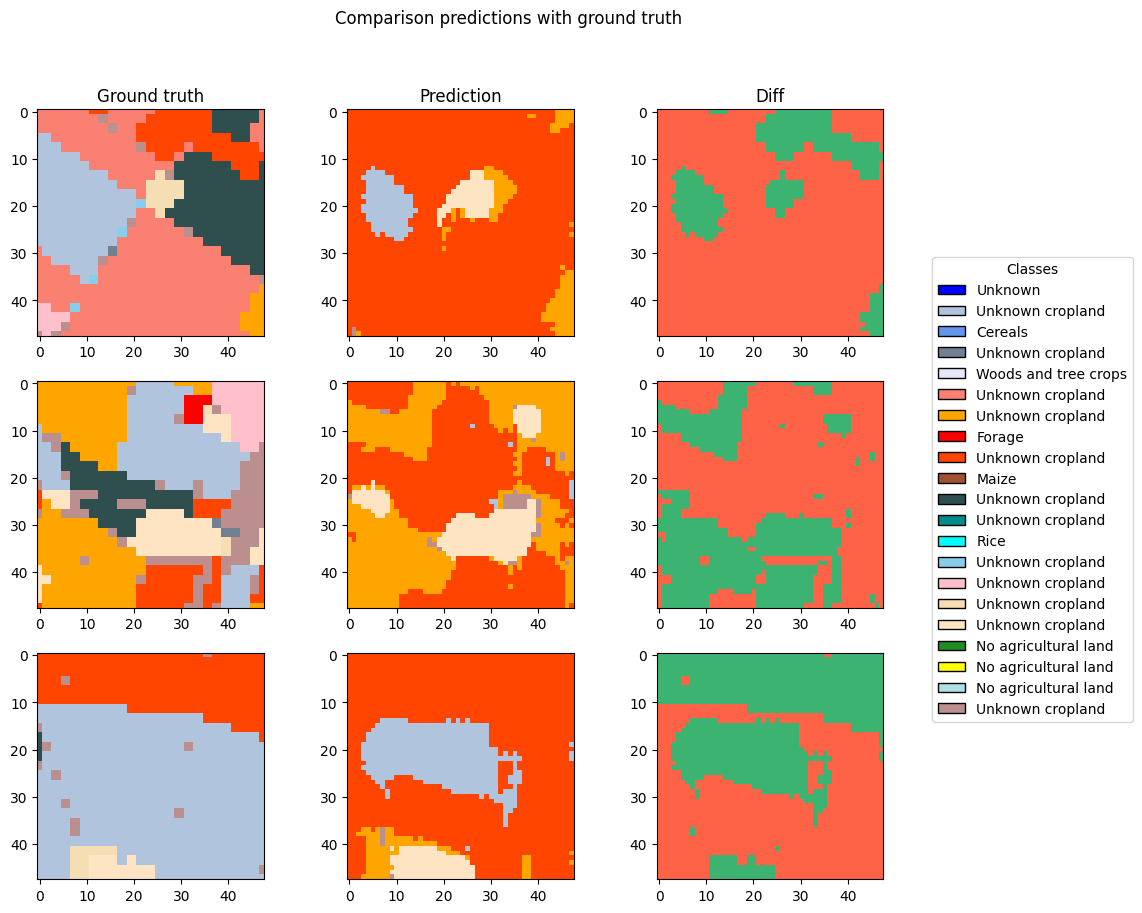

In [188]:
plot_comparison(y_truth_sparse, y_pred_sparse, 21, mapping)

# Temporal Unet model

In [286]:
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, MaxPool3D

def temporal_unet(TIMESTAMP, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((TIMESTAMP, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPool3D(2)(c1)

    c2 = Conv3D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPool3D(2)(c2)

    c3 = Conv3D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPool3D(2)(c3)

    c4 = Conv3D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPool3D((1,2,2))(c4)

    c5 = Conv3D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path

    u6 = Conv3DTranspose(128, (2,2,2), strides=(1,2,2), padding='same')(c5)

    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv3DTranspose(64, 2, strides=(3,2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv3DTranspose(32, 2, strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    print(c8.shape)
    u9 = Conv3DTranspose(16, 2, strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    print(u9.shape)
    c9 = Conv3D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    print(c9.shape)
    outputs = Conv3D(21, 1, activation='softmax', padding='same')(c9)
    print(outputs.shape)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics(21)) #Ignore class to exclude background
    model.summary()

    return model

In [287]:
model = temporal_unet(12, 48, 48, 9)

(None, 6, 24, 24, 32)
(None, 12, 48, 48, 32)
(None, 12, 48, 48, 16)
(None, 12, 48, 48, 21)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 12, 48,    │          0 │ -                 │
│ (InputLayer)        │ 48, 9)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_240 (Conv3D) │ (None, 12, 48,    │      3,904 │ input_layer_24[0… │
│                     │ 48, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_161         │ (None, 12, 48,    │          0 │ conv3d_240[0][0]  │
│ (Dropout)           │ 48, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_241 (Conv3D) │ (None, 12, 48,    │      6,928 │ dropout_161[0][0] │
│                     │ 48, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_69    │ (None, 6, 24, 24, │          0 │ conv3d_241[0][0]  │
│ (MaxPooling3D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_242 (Conv3D) │ (None, 6, 24, 24, │     13,856 │ max_pooling3d_69… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_162         │ (None, 6, 24, 24, │          0 │ conv3d_242[0][0]  │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_243 (Conv3D) │ (None, 6, 24, 24, │     27,680 │ dropout_162[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_70    │ (None, 3, 12, 12, │          0 │ conv3d_243[0][0]  │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_244 (Conv3D) │ (None, 3, 12, 12, │     55,360 │ max_pooling3d_70… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_163         │ (None, 3, 12, 12, │          0 │ conv3d_244[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_245 (Conv3D) │ (None, 3, 12, 12, │    110,656 │ dropout_163[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_71    │ (None, 1, 6, 6,   │          0 │ conv3d_245[0][0]  │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_246 (Conv3D) │ (None, 1, 6, 6,   │    221,312 │ max_pooling3d_71… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_164         │ (None, 1, 6, 6,   │          0 │ conv3d_246[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_247 (Conv3D) │ (None, 1, 6, 6,   │    442,496 │ dropout_164[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_72    │ (None, 1, 3, 3,   │          0 │ conv3d_247[0][0]

 Total params: 5,648,709 (21.55 MB)

 Trainable params: 5,648,709 (21.55 MB)

 Non-trainable params: 0 (0.00 B)

In [246]:
X_temp = np.load('../data/kaggle_dataset/X_temporal.npy')
data_temp = scaling(X_temp, 2, clip=True, temporal=True)
data_temp = np.moveaxis(data_temp, 2, 4)
data_temp.shape

(3328, 12, 48, 48, 9)

In [296]:
y_cat_temp = np.stack([y_cat for i in range(12)], axis=1)

In [297]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(data_temp, y_cat_temp, test_size=0.2)

In [298]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=0
    )

history_temp = model.fit(
    X_train_temp,
    y_train_temp,
    validation_data=(X_test_temp, y_test_temp),
    batch_size=16,
    callbacks=[es],
    epochs=100)


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - io_u_232: 9.0463e-05 - io_u_233: 0.0012 - io_u_234: 1.6588e-04 - io_u_235: 2.0710e-04 - io_u_236: 0.0026 - io_u_237: 4.1606e-04 - io_u_238: 0.0571 - io_u_239: 0.0000e+00 - io_u_240: 0.2993 - io_u_241: 0.0000e+00 - io_u_242: 1.5877e-04 - io_u_243: 0.0000e+00 - io_u_244: 2.2421e-04 - io_u_245: 0.0017 - io_u_246: 0.0038 - io_u_247: 0.0019 - io_u_248: 0.0018 - io_u_249: 0.0000e+00 - io_u_250: 0.0059 - io_u_251: 2.2091e-04 - io_u_252: 5.2997e-05 - loss: 2.5535 - mean_io_u_13: 0.0179 - val_io_u_232: 0.0000e+00 - val_io_u_233: 1.8341e-06 - val_io_u_234: 0.0000e+00 - val_io_u_235: 0.0000e+00 - val_io_u_236: 0.0000e+00 - val_io_u_237: 0.0000e+00 - val_io_u_238: 0.0000e+00 - val_io_u_239: 0.0000e+00 - val_io_u_240: 0.3425 - val_io_u_241: 0.0000e+00 - val_io_u_242: 0.0000e+00 - val_io_u_243: 0.0000e+00 - val_io_u_244: 0.0000e+00 - val_io_u_245: 0.0000e+00 - val_io_u_246: 0.0000e+00 - val_io_u_247: 0.0000e+00 - val_io_u_248: 0.0000e+00 - val_

KeyboardInterrupt: 